In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
from spectral import open_image, envi
from sklearn.preprocessing import MinMaxScaler
import re

# spatial
import xarray as xa
import rasterio
import pyproj
import rioxarray
import xesmf as xe

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import joblib


from sklearn.metrics import r2_score
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from statsmodels.multivariate.manova import MANOVA

# custom
from reflectance import spectrum_utils, file_ops, optimisation_pipeline, plotting, ml_utils

# Attempt 1: matching spectra

In [2]:
corr_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img"
corr_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img.hdr"
mask_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img"
mask_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img.hdr"

hs_mask_metadata = open_image(mask_fp_hdr)
hs_corrected_metadata = open_image(corr_fp_hdr)
print("masked:", hs_mask_metadata)
print("corrected:", hs_corrected_metadata)
hs_corrected_data = open_image(corr_fp_hdr).load()

masked: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_mask_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:             1
	Interleave:        BSQ
	Quantization:   8 bits
	Data format:     uint8
corrected: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_corr_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:           246
	Interleave:        BSQ
	Quantization:  32 bits
	Data format:   float32


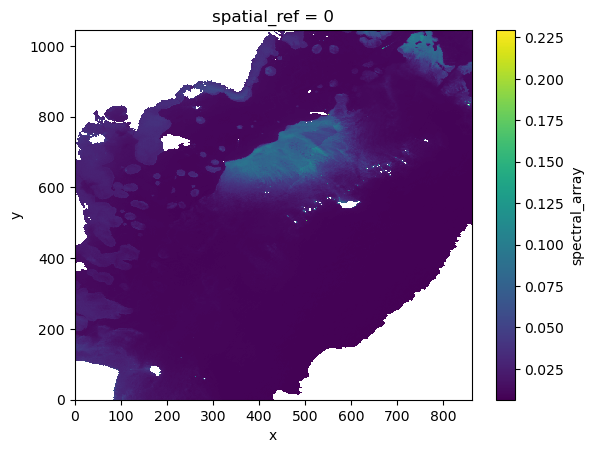

In [3]:
from pyproj import Transformer

def envi_to_xarray_with_latlon(envi_fp, band_vals: list[float]=None):
    # Open the ENVI file using rasterio
    with rasterio.open(envi_fp) as src:
        data = src.read()
        transform = src.transform
        height, width = src.shape

        # generate UTM coordinates from pixel indices using the affine transform
        x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
        x_coords, y_coords = rasterio.transform.xy(transform, y_coords, x_coords)

        # Convert the UTM coordinates to numpy arrays
        x_coords = np.array(x_coords)
        y_coords = np.array(y_coords)

        # Convert UTM to lat/lon using pyproj or rasterio's CRS info
        transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
        lon_coords, lat_coords = transformer.transform(x_coords, y_coords)

        # Reshape lat and lon arrays to match the image dimensions
        lat_coords = np.reshape(lat_coords, (height, width))
        lon_coords = np.reshape(lon_coords, (height, width))

        # Create the xarray Dataset with lat/lon as coordinates
        dataset = xa.DataArray(
            data=data,  # The raster data
            dims=("band", "y", "x"),  # Dimensions of the data (e.g., bands, rows, cols)
            coords={
                "lat": (["y", "x"], lat_coords),  # Latitude coordinates (reshaped)
                "lon": (["y", "x"], lon_coords),  # Longitude coordinates (reshaped)
                "band": band_vals if band_vals else np.arange(1, data.shape[0] + 1),  # Band indices
            },
            attrs=src.meta  # Include the ENVI metadata
        )
        # convert nan values (-9999) to np.nan
        dataset = dataset.where(dataset != -9999, np.nan)
        dataset.rio.write_crs( "EPSG:4326", inplace=True)
    return dataset

spatial_xy_xa = envi_to_xarray_with_latlon(corr_fp)
mask_xa = envi_to_xarray_with_latlon(mask_fp)
# broadcast mask_xa to have same number of bands as scene_xa
mask_xa = mask_xa.broadcast_like(spatial_xy_xa)
mask_xa.values = np.broadcast_to(mask_xa.values[0], mask_xa.shape)
masked_scene_xa = spatial_xy_xa.where(mask_xa == 1, np.nan)
masked_scene_xa.name = "spectral_array"
# assign band values actual wavelength values
masked_scene_xa.coords["band"] = hs_corrected_metadata.bands.centers

# visualise data
mean_scene_xa = masked_scene_xa.median(dim="band", skipna=True)
mean_scene_xa.plot.imshow();

In [4]:
# matching spectra
validation_spectra_fp = file_ops.DATA_DIR_FP / "CORAL_validation_spectra.csv"
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
validation_spectra = pd.read_csv(validation_spectra_fp)
validation_spectra.columns = validation_spectra.columns.astype(float)
kbay_indices = validation_data[validation_data.Locale == "Kaneohe Bay"].index
# select kbay spectra
kbay_validation_spectra = validation_spectra.iloc[kbay_indices]
kbay_validation_spectra.head()

350.718103   353.548360   356.378673   359.209042   362.039467   \
1151      -0.0936      -0.0753       0.0055       0.0092       0.0261   
1152      -0.1003      -0.0732       0.0104       0.0123       0.0251   
1153      -0.0942      -0.0749       0.0012       0.0124       0.0233   
1154      -0.0933      -0.0721       0.0007       0.0100       0.0232   
1155      -0.1004      -0.0798      -0.0035       0.0052       0.0208   

      364.869949   367.700487   370.531081   373.361731   376.192438   ...  \
1151       0.0194       0.0168       0.0170       0.0169       0.0213  ...   
1152       0.0189       0.0178       0.0199       0.0180       0.0227  ...   
1153       0.0247       0.0194       0.0187       0.0168       0.0208  ...   
1154       0.0218       0.0167       0.0204       0.0158       0.0201  ...   
1155       0.0164       0.0109       0.0154       0.0125       0.0159  ...   

      1020.218215  1023.061744  1025.905330  1028.748971  1031.592670  \
1151       0.0076       0.0070       0.0067       0.0071       0.0076   
1152       0.0073       0.0077       0.0072       0.0069       0.0069   
1153       0.0071       0.0069       0.0071       0.0072       0.0072   
1154       0.0068       0.0066       0.0064       0.0065       0.0064   
1155       0.0073       0.0069       0.0070       0.0075       0.0076   

      1034.436424  1037.280234  1040.124101  1042.968024  1045.812003  
1151       0.0061       0.0072       0.0068       0.0070       0.0072  
1152       0.0075       0.0073       0.0078       0.0077       0.0073  
1153       0.0072       0.0067       0.0068       0.0069       0.0068  
1154       0.0069       0.0070       0.0071       0.0060       0.0063  
1155       0.0078       0.0078       0.0078       0.0084       0.0075  

[5 rows x 246 columns]

In [5]:
kbay_spectra = ml_utils.spectral_xa_to_processed_spectral_df(masked_scene_xa, sensor_range = [kbay_validation_spectra.columns.min(), kbay_validation_spectra.columns.max()+10]) # discrepancy in wavelength values much!!
kbay_spectra_no_nans = kbay_spectra.dropna(inplace=False)
kbay_spectra_no_nans.head()

350.718109   353.548370   356.378662   359.209045   362.039459   \
84    -0.226065    -0.173343     0.029054     0.026362     0.048827   
85    -0.185080    -0.145685     0.031734     0.042032     0.056400   
86    -0.185541    -0.129247     0.039026     0.036056     0.053762   
87    -0.177682    -0.122697     0.040667     0.046347     0.061807   
88    -0.177682    -0.122697     0.040667     0.046347     0.061807   

    364.869934   367.700500   370.531067   373.361725   376.192444   ...  \
84     0.039588     0.029481     0.023329     0.017586     0.022286  ...   
85     0.049959     0.036195     0.036955     0.023494     0.027282  ...   
86     0.046651     0.035294     0.030869     0.022162     0.028531  ...   
87     0.045808     0.036235     0.036893     0.023296     0.029488  ...   
88     0.045808     0.036235     0.036893     0.023296     0.029488  ...   

    1020.218201  1023.061768  1025.905273  1028.749023  1031.592651  \
84     0.003392     0.002484     0.004786     0.006878     0.006311   
85    -0.004237    -0.004126    -0.003085    -0.002034     0.000286   
86    -0.000491     0.001376     0.001426     0.003975     0.003139   
87     0.000901     0.001693     0.002987     0.003684     0.004522   
88     0.000901     0.001693     0.002987     0.003684     0.004522   

    1034.436401  1037.280273  1040.124146  1042.968018  1045.812012  
84     0.009455     0.009783     0.012087     0.013919     0.016255  
85     0.002187     0.001824     0.002732     0.004041     0.006909  
86     0.004987     0.006605     0.008619     0.009294     0.010524  
87     0.004675     0.006394     0.006645     0.008309     0.011872  
88     0.004675     0.006394     0.006645     0.008309     0.011872  

[5 rows x 246 columns]

In [6]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree

# Build KDTree for kbay_spectra (the dataset to be searched for the closest spectra)
tree = KDTree(kbay_spectra_no_nans.values)

# Query the KDTree to find the nearest neighbor in kbay_spectra for each spectrum in kbay_validation_spectra
# This returns both the distance and the index of the closest point in kbay_spectra
distances, indices = tree.query(kbay_validation_spectra.values, k=1)  # k=1 finds the single closest match

In [7]:
kbay_spectra_no_nans

350.718109   353.548370   356.378662   359.209045   362.039459   \
84        -0.226065    -0.173343     0.029054     0.026362     0.048827   
85        -0.185080    -0.145685     0.031734     0.042032     0.056400   
86        -0.185541    -0.129247     0.039026     0.036056     0.053762   
87        -0.177682    -0.122697     0.040667     0.046347     0.061807   
88        -0.177682    -0.122697     0.040667     0.046347     0.061807   
...             ...          ...          ...          ...          ...   
901830    -0.196233    -0.136284     0.036979     0.041104     0.075436   
901831    -0.205698    -0.138908     0.051432     0.054575     0.076643   
901832    -0.211574    -0.128616     0.041478     0.048422     0.078161   
901833    -0.196651    -0.128256     0.052801     0.055943     0.079267   
901834    -0.205745    -0.129950     0.047893     0.054252     0.075716   

        364.869934   367.700500   370.531067   373.361725   376.192444   ...  \
84         0.039588     0.029481     0.023329     0.017586     0.022286  ...   
85         0.049959     0.036195     0.036955     0.023494     0.027282  ...   
86         0.046651     0.035294     0.030869     0.022162     0.028531  ...   
87         0.045808     0.036235     0.036893     0.023296     0.029488  ...   
88         0.045808     0.036235     0.036893     0.023296     0.029488  ...   
...             ...          ...          ...          ...          ...  ...   
901830     0.070244     0.063448     0.066963     0.056230     0.063454  ...   
901831     0.072342     0.064835     0.065242     0.059031     0.063625  ...   
901832     0.067005     0.062965     0.066848     0.058741     0.064208  ...   
901833     0.068772     0.061382     0.069132     0.056517     0.069051  ...   
901834     0.070626     0.066939     0.064788     0.052790     0.068016  ...   

        1020.218201  1023.061768  1025.905273  1028.749023  1031.592651  \
84         0.003392     0.002484     0.004786     0.006878     0.006311   
85        -0.004237    -0.004126    -0.003085    -0.002034     0.000286   
86        -0.000491     0.001376     0.001426     0.003975     0.003139   
87         0.000901     0.001693     0.002987     0.003684     0.004522   
88         0.000901     0.001693     0.002987     0.003684     0.004522   
...             ...          ...          ...          ...          ...   
901830    -0.000908    -0.000746    -0.000518    -0.001035     0.000813   
901831    -0.001031    -0.000384    -0.001158    -0.000316    -0.000444   
901832    -0.000047    -0.001585    -0.000621    -0.000632     0.000291   
901833    -0.001095     0.000027    -0.000986    -0.002144    -0.000336   
901834    -0.000974    -0.001306    -0.000983     0.000180    -0.001095   

        1034.436401  1037.280273  1040.124146  1042.968018  1045.812012  
84         0.009455     0.009783     0.012087     0.013919     0.016255  
85         0.002187     0.001824     0.002732     0.004041     0.006909  
86         0.004987     0.006605     0.008619     0.009294     0.010524  
87         0.004675     0.006394     0.006645     0.008309     0.011872  
88         0.004675     0.006394     0.006645     0.008309     0.011872  
...             ...          ...          ...          ...          ...  
901830     0.000199     0.001249     0.000073     0.000067    -0.000180  
901831     0.001594     0.000629     0.000618     0.002423     0.001180  
901832    -0.000907     0.000723    -0.000003     0.002360     0.001193  
901833    -0.000517     0.000158     0.000782    -0.000176     0.001317  
901834     0.001228    -0.000011     0.001243     0.002387     0.001900  

[711683 rows x 246 columns]

In [8]:
# how many of "indices" are in kbay_spectra_no_nans?
len(kbay_spectra_no_nans.iloc[indices].dropna())

421

In [9]:
pd.DataFrame(kbay_spectra.index.isin(indices).astype(float), columns=["site"])

site
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
...      ...
901830   0.0
901831   0.0
901832   0.0
901833   0.0
901834   0.0

[901835 rows x 1 columns]

In [10]:
site_df = pd.DataFrame(kbay_spectra.index.isin(indices).astype(float), columns=["site"])

site_array = xa.DataArray(
    data=site_df.values.reshape(masked_scene_xa.shape[1], masked_scene_xa.shape[2]), 
    coords={"lat": masked_scene_xa.coords["lat"], "lon": masked_scene_xa.coords["lon"]}, 
    dims=("y", "x"), 
    name="site"
)
site_array.rio.write_crs(masked_scene_xa.rio.crs, inplace=True)

site_array = site_array.assign_coords(
    x=np.arange(masked_scene_xa.sizes['x']),
    y=np.arange(masked_scene_xa.sizes['y'])
)


# merge with masked_scene_xa
scene_site_xa = xa.merge([site_array, masked_scene_xa])
scene_site_xa.rio.write_crs(masked_scene_xa.rio.crs, inplace=True)

scene_site_xa = scene_site_xa.assign_coords(
    x=np.arange(scene_site_xa.sizes['x']),
    y=np.arange(scene_site_xa.sizes['y'])
)

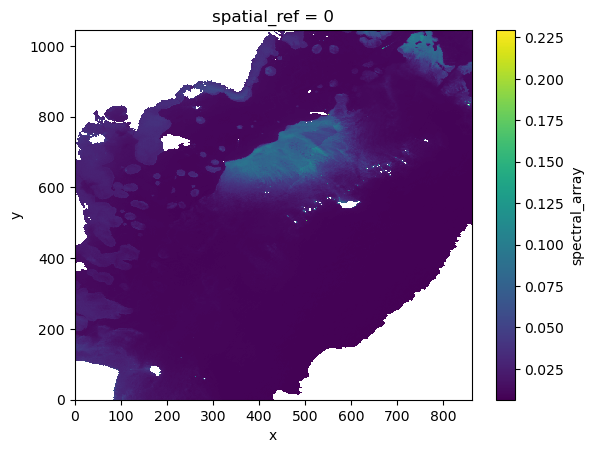

In [11]:
scene_site_xa.spectral_array.median(dim="band", skipna=True).plot.imshow();

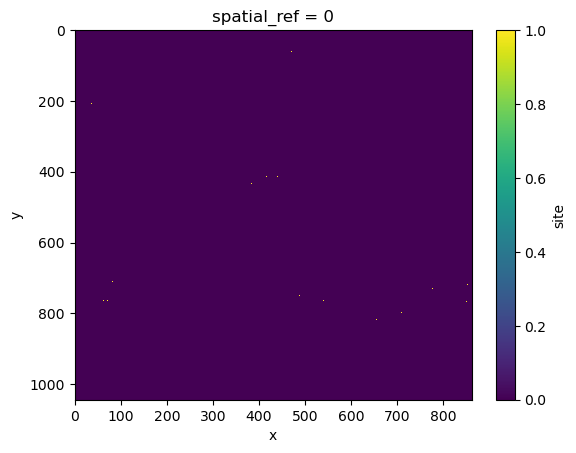

In [12]:
scene_site_xa.site.plot.imshow();
plt.gca().invert_yaxis()
# plot as scatter the validation locations (from X and Y columns)

In [13]:
print("retrieved spectra:", len(indices))
print("og spectra:", len(kbay_validation_spectra))

retrieved spectra: 421
og spectra: 421


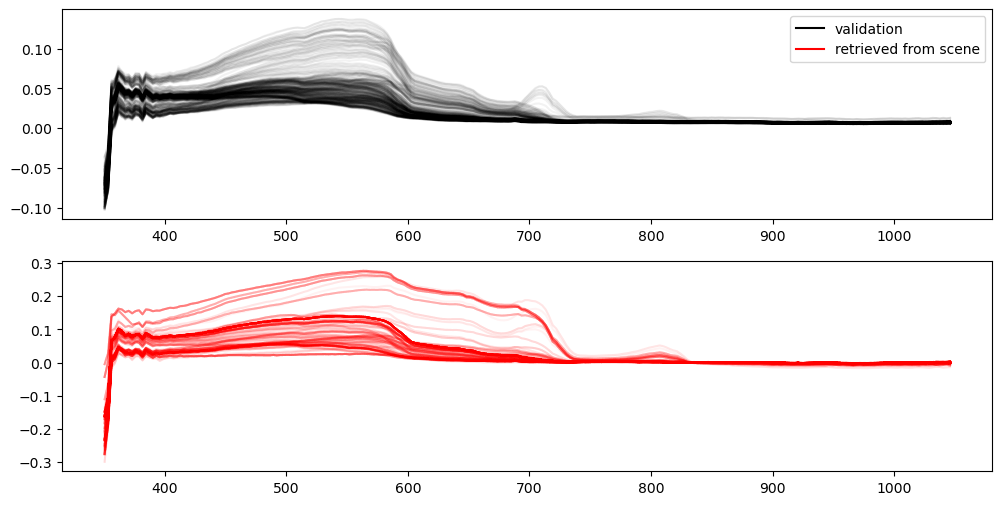

In [19]:
# plot the retrieved spectra and the validation spectra
fig, ax = plt.subplots(2, figsize=(12, 6))
ax[0].plot(kbay_validation_spectra.T, c="k", alpha=0.05);
# retrieved spectra 
retrieved_spectra = kbay_spectra.iloc[indices]
ax[1].plot(retrieved_spectra.T, c="r", alpha=0.05);

ax[0].plot([], c="k", label="validation")
ax[0].plot([], c="r", label="retrieved from scene")
ax[0].legend();

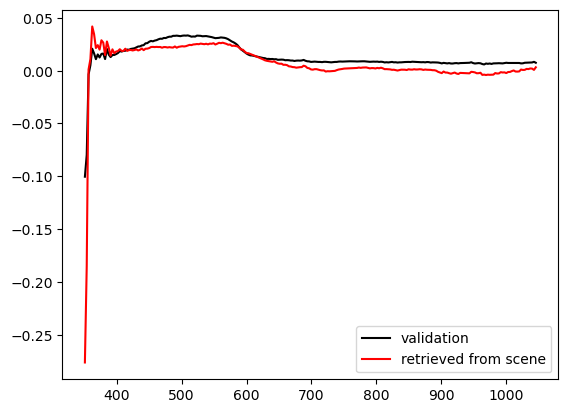

In [ ]:
i = 4
plt.plot(kbay_validation_spectra.iloc[i], c="k", label="validation")
plt.plot(retrieved_spectra.iloc[i], c="r", label="retrieved from scene")
plt.legend()

In [ ]:
test_site_xa = ml_utils.regrid_with_xesmf(site_array)

In [ ]:
test_scene_xa = ml_utils.regrid_with_xesmf(masked_scene_xa)

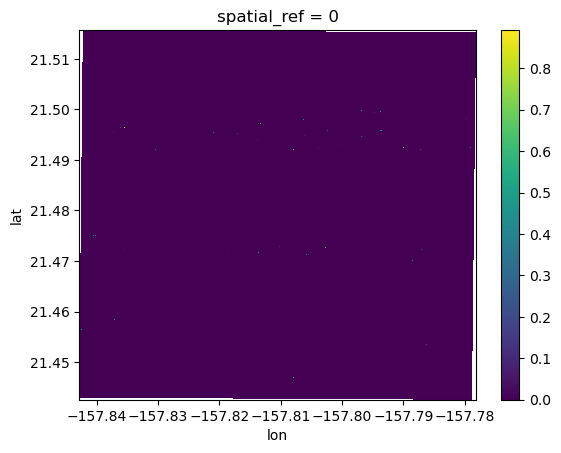

In [ ]:
test_site_xa.plot.imshow();

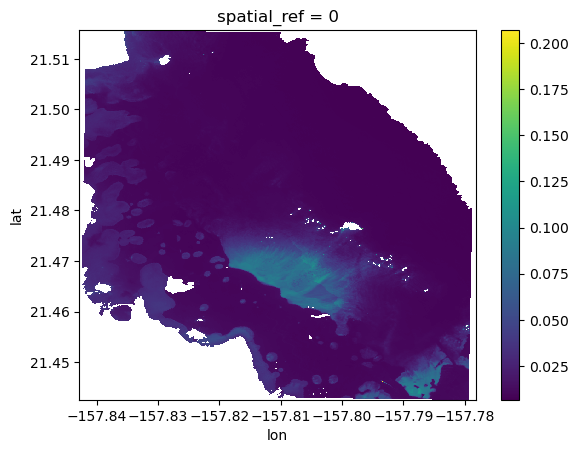

In [ ]:
test_scene_xa.median(dim="band", skipna=True).plot.imshow();

In [ ]:
test_site_xa.name = "site"
test_scene_xa.name = "spectral_array"

In [ ]:
# merge
test_scene_site_xa = xa.merge([test_site_xa, test_scene_xa])

In [ ]:
(~np.isnan(test_scene_site_xa.site.values)).shape

(1045, 863)

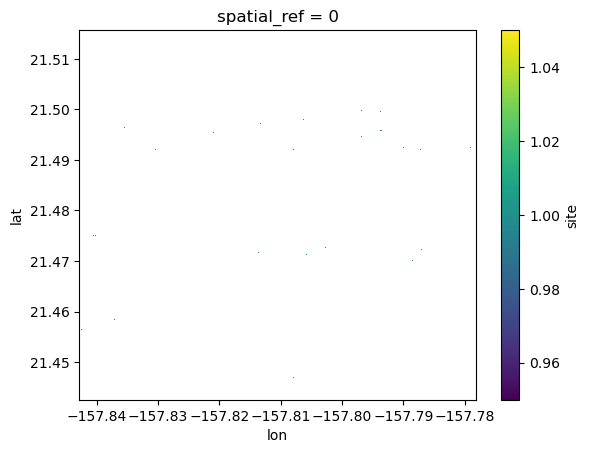

In [ ]:
# cast all values below 0.1 to nan, all above to 1
test_scene_site_xa.site.values[test_scene_site_xa.site.values < 0.2] = np.nan
test_scene_site_xa.site.values[test_scene_site_xa.site.values >= 0.2] = 1
test_scene_site_xa.site.plot.imshow();

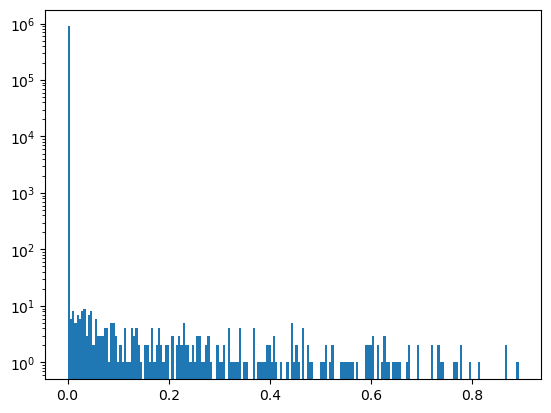

In [ ]:
plt.hist(test_scene_site_xa.site.values.flatten(), bins=200);
plt.yscale("log")

In [ ]:
np.nansum(test_scene_site_xa.site.values.flatten() != 0)

15990

In [ ]:
# np.nansum(test_scene_site_xa.site.values)
np.nansum(test_site_xa.values)

55.0

In [ ]:
test_scene_site_xa.spectral_array.values.shape

(246, 1045, 863)

In [ ]:
test_scene_site_xa

<xarray.Dataset> Size: 895MB
Dimensions:         (lat: 1045, lon: 863, band: 246)
Coordinates:
  * lat             (lat) float64 8kB 21.44 21.44 21.44 ... 21.52 21.52 21.52
  * lon             (lon) float64 7kB -157.8 -157.8 -157.8 ... -157.8 -157.8
    spatial_ref     int64 8B 0
  * band            (band) float64 2kB 350.7 353.5 356.4 ... 1.043e+03 1.046e+03
Data variables:
    site            (lat, lon) float64 7MB nan nan nan nan ... nan nan nan nan
    spectral_array  (band, lat, lon) float32 887MB nan nan nan ... nan nan nan
Attributes:
    _FillValue:  nan

In [ ]:
# create a grid of latitude and longitude values
lat = np.linspace(test_scene_site_xa.lat.min(), test_scene_site_xa.lat.max(), test_scene_site_xa.sizes["lat"])
lon = np.linspace(test_scene_site_xa.lon.min(), test_scene_site_xa.lon.max(), test_scene_site_xa.sizes["lon"])
lat, lon = np.meshgrid(lat, lon)
lon.shape

(863, 1045)

In [ ]:
# site_x, site_y = np.where(~np.isnan(test_scene_site_xa.site.values))
# retrieve all spectra at these locations
test_scene_site_xa.spectral_array.values[:, site_x, site_y].shape

(246, 148)

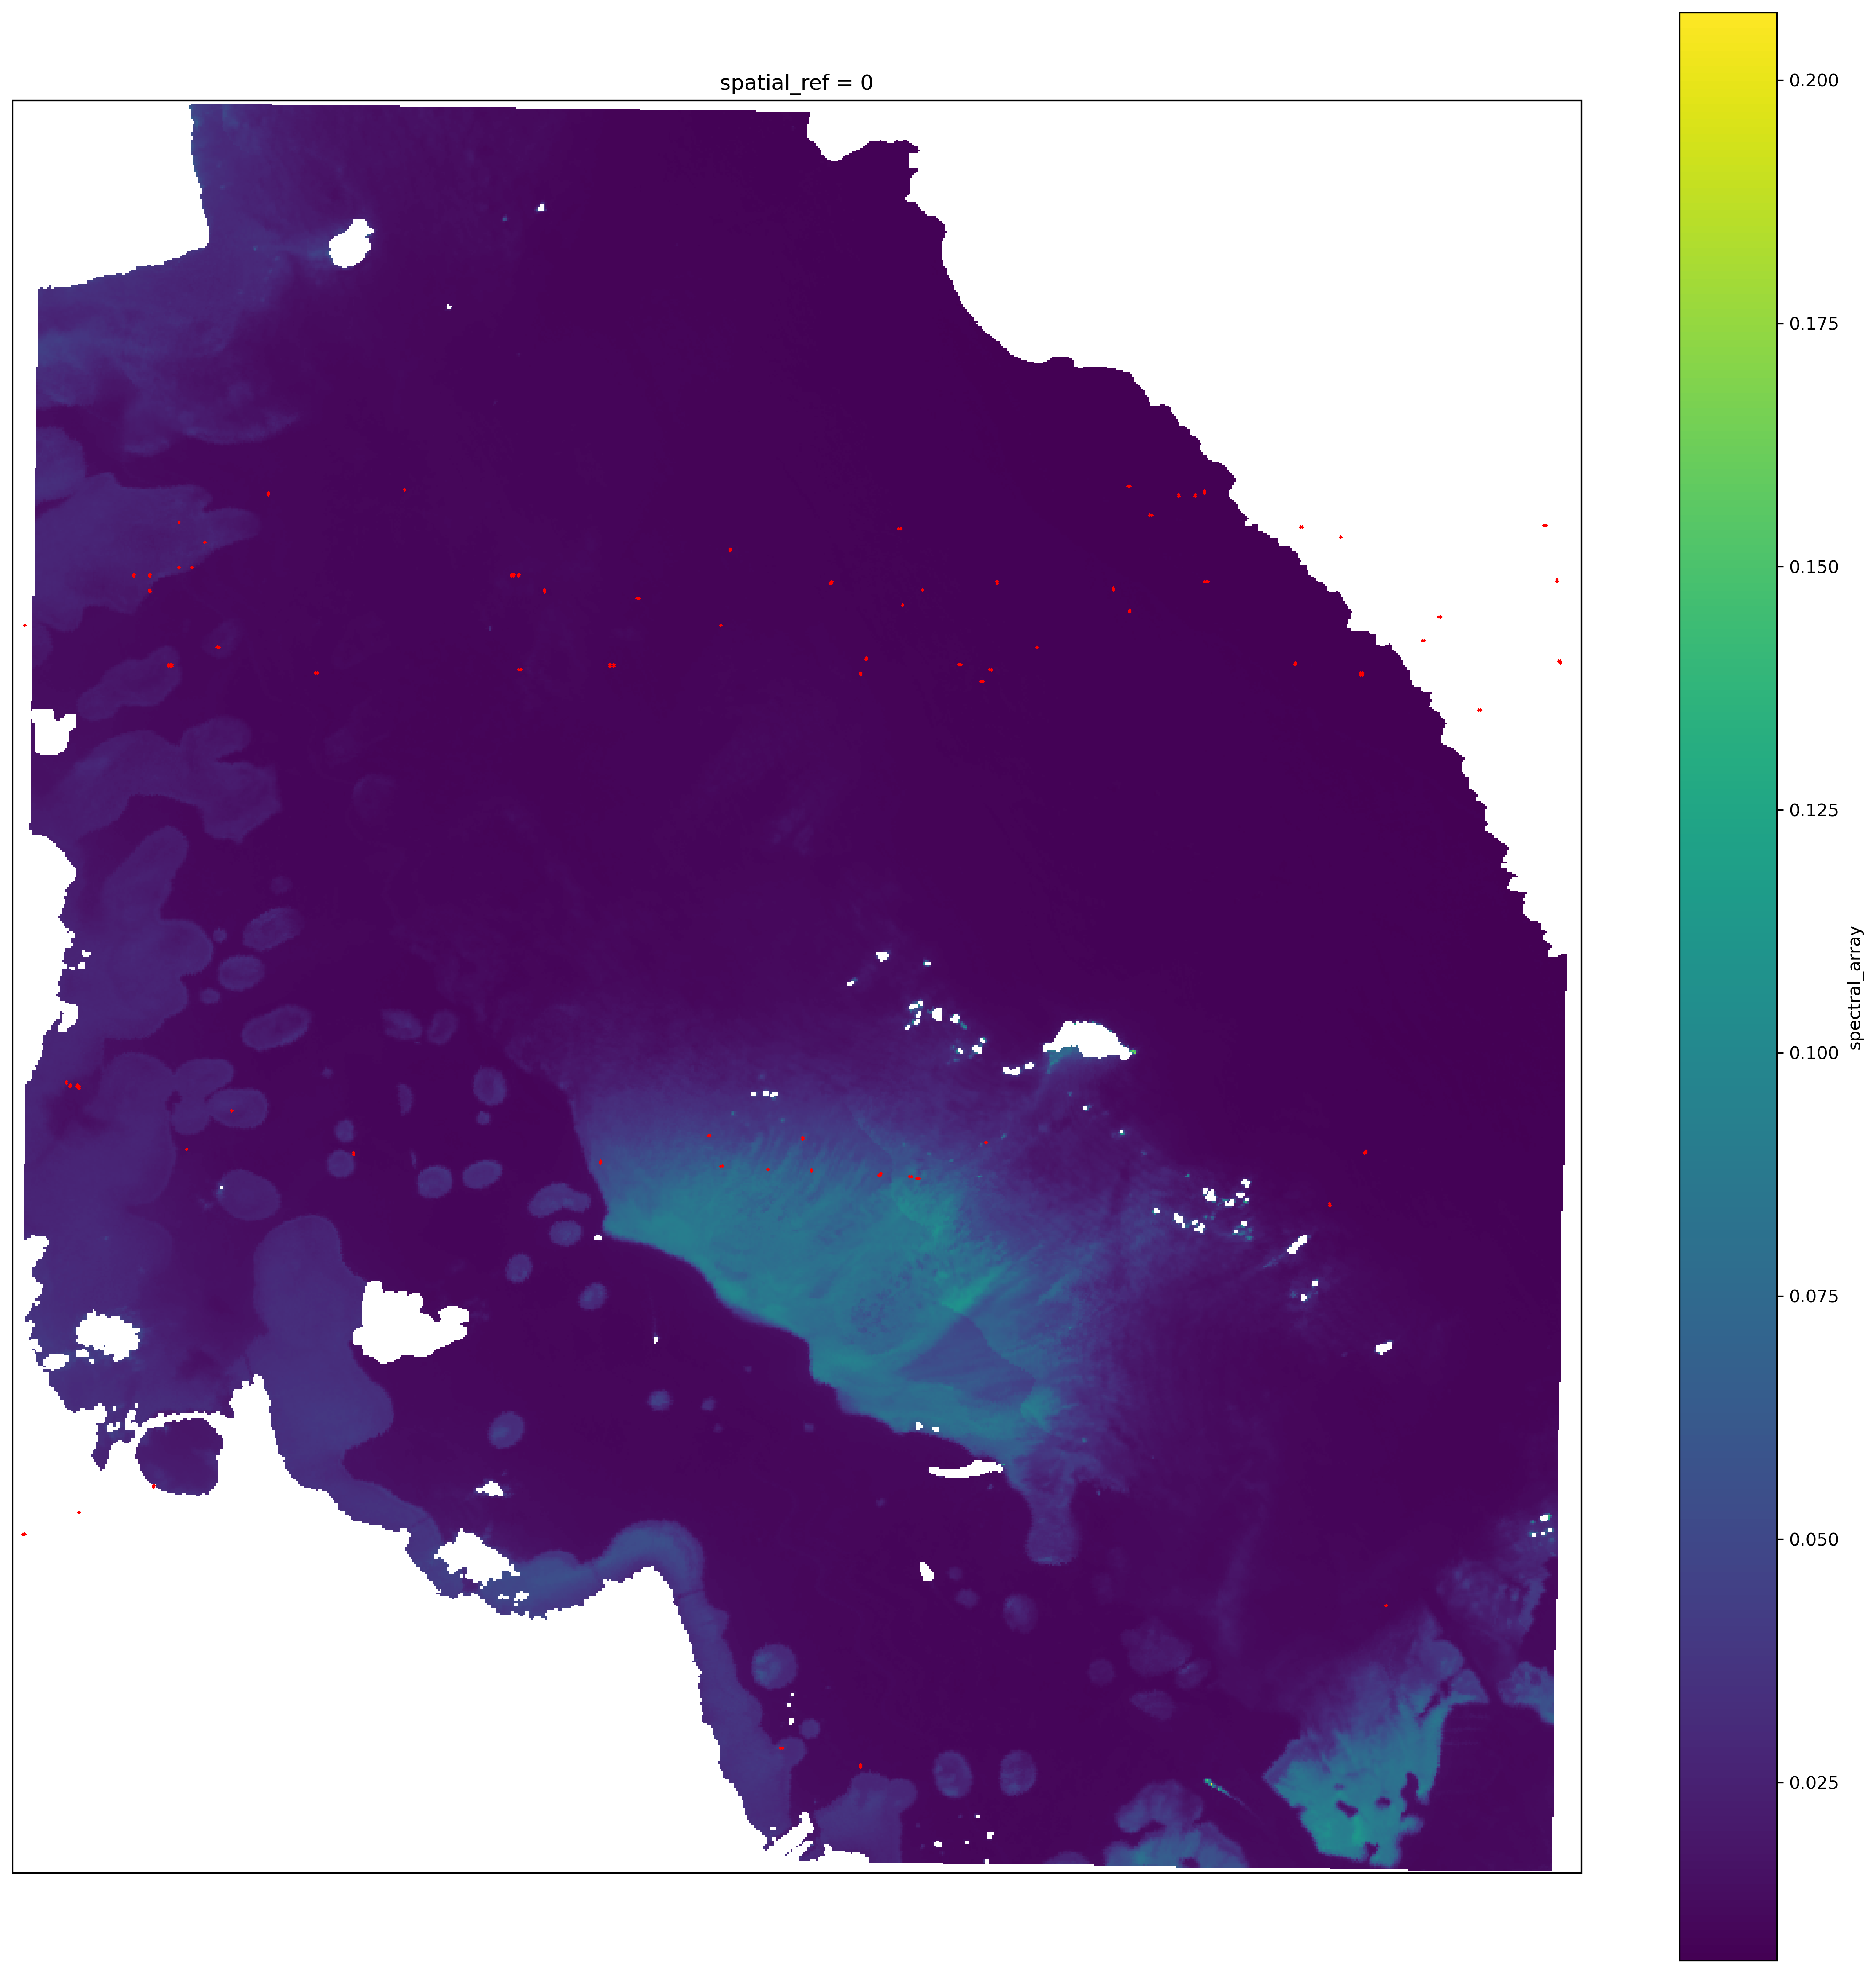

In [ ]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 20), dpi=300)
test_scene_site_xa.spectral_array.median(dim="band", skipna=True).plot(ax=ax, transform=ccrs.PlateCarree())

# plot non-nan site values as scatter points
site_x, site_y = np.where(~np.isnan(test_scene_site_xa.site.values))
# select latitude and longitude values by index (site_x, site_y)
latitudes = [lat[site_y[i], site_x[i]] for i in range(len(site_x))] 
longitudes = [lon[site_y[i], site_x[i]] for i in range(len(site_y))]

ax.scatter(longitudes, latitudes, c="r", s=1, marker="x", transform=ccrs.PlateCarree())

# Attempt 2: index method

In [4]:
kaneohe_ds = xa.open_dataset(file_ops.KANEOHE_HS_FP).site
validation_spectra = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_spectra.csv")
validation_metadata = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
kbay_inds = validation_metadata[validation_metadata.Locale == "Kaneohe Bay"].index

In [5]:
validation_spectra.columns = validation_spectra.columns.astype(float)
kbay_validation_spectra = validation_spectra.iloc[kbay_inds].reset_index(drop=True)
kbay_validation_spectra.columns = kbay_validation_spectra.columns.astype(float)
kbay_metadata = validation_metadata.iloc[kbay_inds].reset_index(drop=True)
# trim metadata to only include values within the bounds of the kaneohe dataset
# spatial_extent_inds = (kaneohe_ds.lon.values.min() <= kbay_metadata.X) & (kbay_metadata.X <= kaneohe_ds.lon.values.max()) & (kaneohe_ds.lat.values.min() <= kbay_metadata.Y) & (kbay_metadata.Y <= kaneohe_ds.lat.values.max())
# # removing these sets things off-kilter further down the line: process later
# kbay_metadata = kbay_metadata[spatial_extent_inds]
# kbay_validation_spectra = kbay_validation_spectra[spatial_extent_inds]


In [6]:
spectra_vals = kaneohe_ds.values.reshape(kaneohe_ds.shape[0], -1).T
wvs = kaneohe_ds.coords["band"].values
kaneohe_df = pd.DataFrame(spectra_vals, columns=wvs)

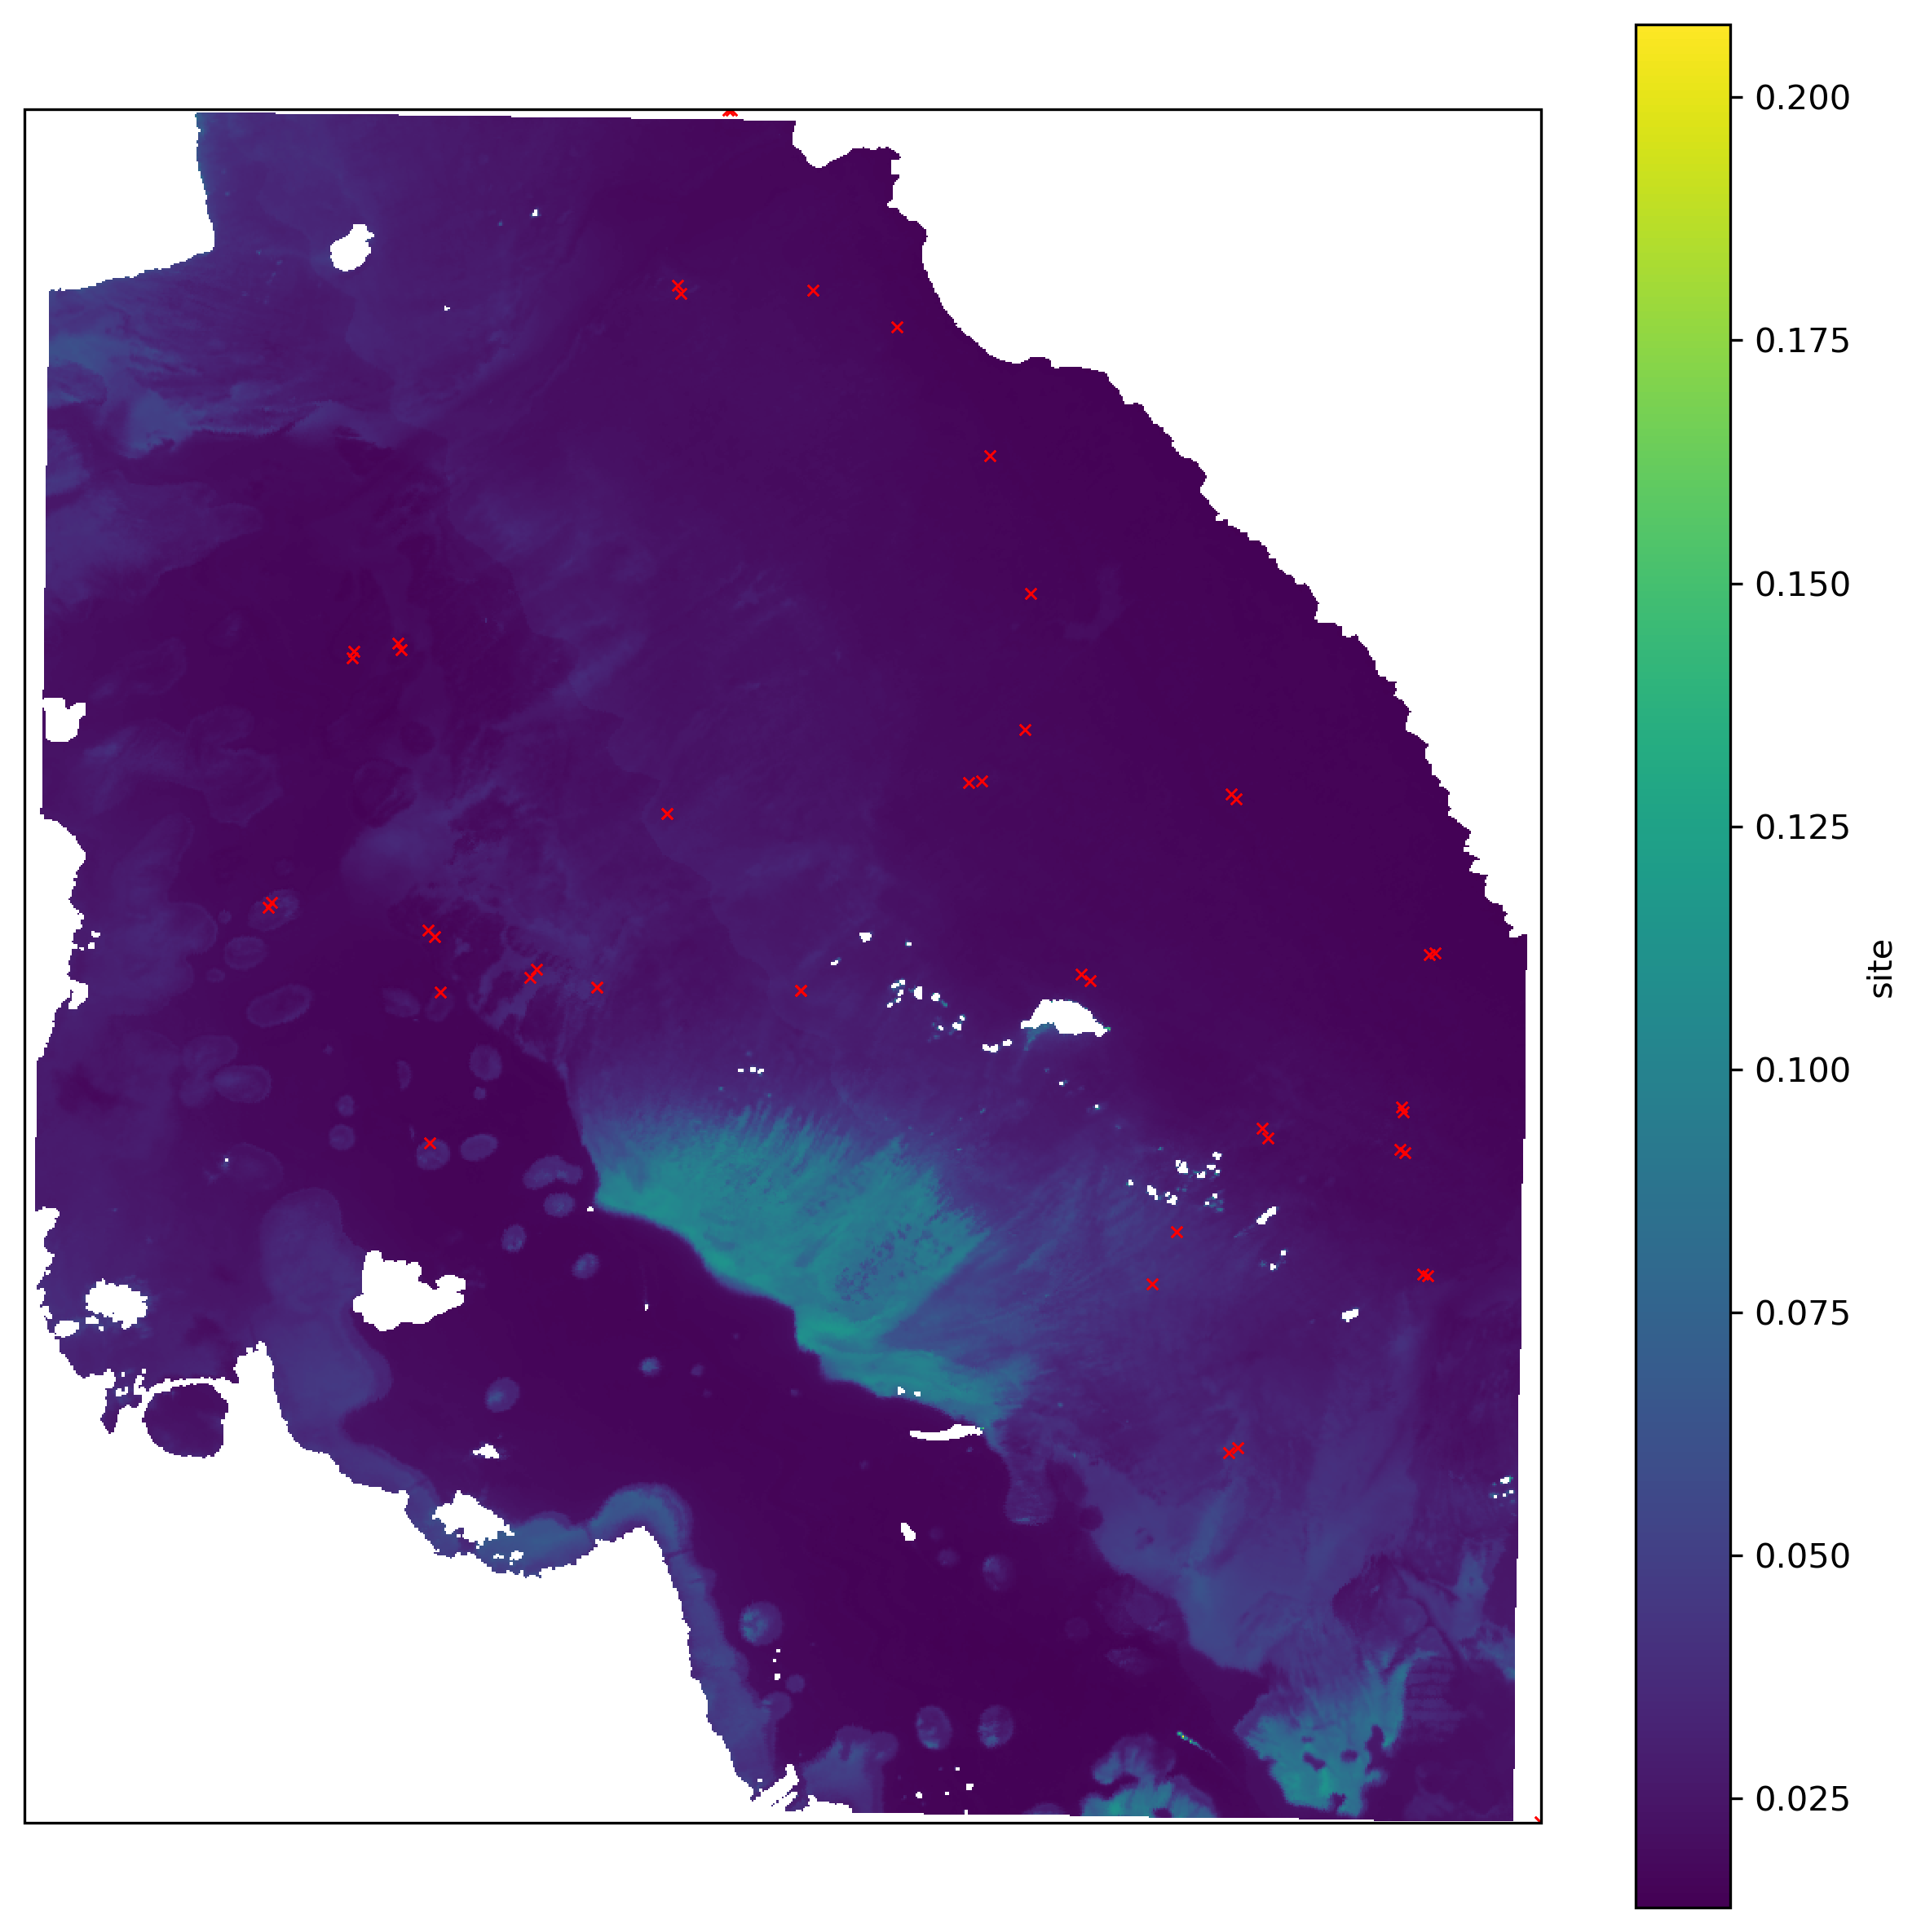

In [7]:
# get spectra from kaneohe_ds
matched_data = pd.DataFrame()
matched_data["pixel_x"] = np.argmin(np.abs(kaneohe_ds.lon.values - kbay_metadata.X.values[:, np.newaxis]), axis=1)
matched_data["pixel_y"] = np.argmin(np.abs(kaneohe_ds.lat.values - kbay_metadata.Y.values[:, np.newaxis]), axis=1)
# get spectra (bands) at these pixel locations:
matched_spectra = pd.DataFrame(kaneohe_ds.values[:, matched_data.pixel_y, matched_data.pixel_x].T, columns=wvs)

matched_data = pd.concat([kbay_metadata.reset_index(drop=True), matched_data.reset_index(drop=True), matched_spectra.reset_index(drop=True)], axis=1)

# plot kaneohe_ds
fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10), dpi=300)
kaneohe_ds.mean(dim="band", skipna=True).plot(ax=ax, transform=ccrs.PlateCarree())
# plot matched points as scatter
ax.scatter(kaneohe_ds.lon.values[matched_data.pixel_x], kaneohe_ds.lat.values[matched_data.pixel_y], c="r", s=10, marker="x", transform=ccrs.PlateCarree(), lw=0.5)

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_71867/642232808.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


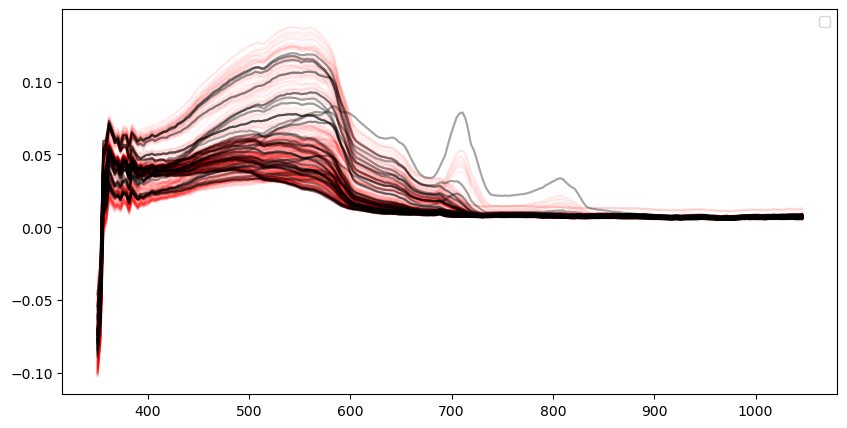

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
plt.plot(kbay_validation_spectra.T, c="r", alpha=0.05);
plt.plot(matched_spectra.T, c="k", alpha=0.05);
plt.legend()

## Those don't match, going to take average

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


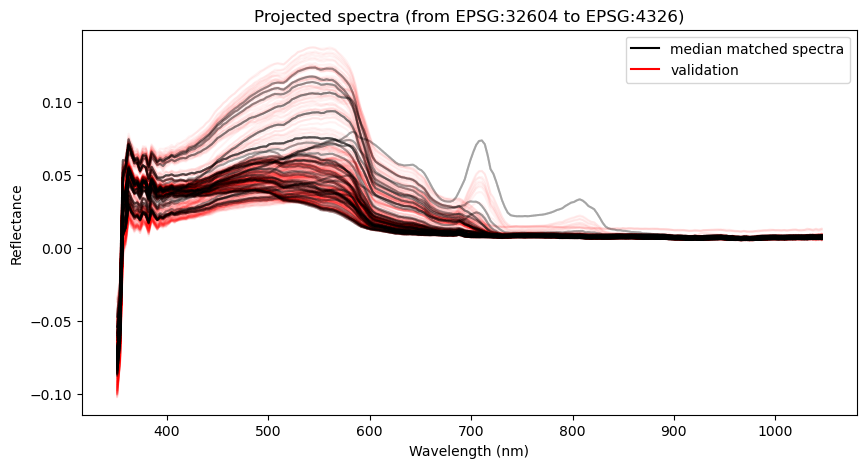

In [9]:
# get spectra from kaneohe_ds
matched_data = pd.DataFrame()
matched_data["pixel_x"] = np.argmin(np.abs(kaneohe_ds.lon.values - kbay_metadata.X.values[:, np.newaxis]), axis=1)
matched_data["pixel_y"] = np.argmin(np.abs(kaneohe_ds.lat.values - kbay_metadata.Y.values[:, np.newaxis]), axis=1)

# Initialize a list to store the spectra of the surrounding pixels
all_spectra = []
median_spectra = []
# Loop through each matched pixel and get the spectra of the surrounding pixels
for i in range(len(matched_data)):
    x = matched_data.pixel_x[i]
    y = matched_data.pixel_y[i]
    
    spectra = kaneohe_ds.values[:, y-1:y+2, x-1:x+2].reshape(kaneohe_ds.shape[0], -1)
    all_spectra.append(spectra.T)
    median_spectra.append(np.median(spectra, axis=1))

# Convert the list of spectra to a DataFrame
median_matched_spectra = pd.DataFrame(median_spectra, columns=wvs)

median_matched_data = pd.concat([kbay_metadata.reset_index(drop=True), matched_data.reset_index(drop=True), matched_spectra.reset_index(drop=True)], axis=1)

fig, ax = plt.subplots(1,1, figsize=(10, 5))
plt.plot(kbay_validation_spectra.T, c="r", alpha=0.05)
plt.plot(median_matched_spectra.T, c="k", alpha=0.05)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")

plt.plot([], c="k", label="median matched spectra")
plt.plot([], c="r", label="validation")
plt.title("Projected spectra (from EPSG:32604 to EPSG:4326)")
plt.legend();

In [10]:
median_matched_spectra

350.718109   353.548370   356.378662   359.209045   362.039459   \
0      -0.080781    -0.057066     0.018404     0.026883     0.043596   
1      -0.080781    -0.057066     0.018404     0.026883     0.043596   
2      -0.080781    -0.057066     0.018404     0.026883     0.043596   
3      -0.080781    -0.057066     0.018404     0.026883     0.043596   
4      -0.085959    -0.064735     0.008399     0.014063     0.028025   
..           ...          ...          ...          ...          ...   
416          NaN          NaN          NaN          NaN          NaN   
417          NaN          NaN          NaN          NaN          NaN   
418          NaN          NaN          NaN          NaN          NaN   
419          NaN          NaN          NaN          NaN          NaN   
420          NaN          NaN          NaN          NaN          NaN   

     364.869934   367.700500   370.531067   373.361725   376.192444   ...  \
0       0.040594     0.037493     0.037013     0.034024     0.039850  ...   
1       0.040594     0.037493     0.037013     0.034024     0.039850  ...   
2       0.040594     0.037493     0.037013     0.034024     0.039850  ...   
3       0.040594     0.037493     0.037013     0.034024     0.039850  ...   
4       0.023779     0.019934     0.021533     0.018814     0.023522  ...   
..           ...          ...          ...          ...          ...  ...   
416          NaN          NaN          NaN          NaN          NaN  ...   
417          NaN          NaN          NaN          NaN          NaN  ...   
418          NaN          NaN          NaN          NaN          NaN  ...   
419          NaN          NaN          NaN          NaN          NaN  ...   
420          NaN          NaN          NaN          NaN          NaN  ...   

     1020.218201  1023.061768  1025.905273  1028.749023  1031.592651  \
0       0.008106     0.008258     0.008105     0.008296     0.008271   
1       0.008106     0.008258     0.008105     0.008296     0.008271   
2       0.008106     0.008258     0.008105     0.008296     0.008271   
3       0.008106     0.008258     0.008105     0.008296     0.008271   
4       0.008058     0.007793     0.007972     0.007934     0.007975   
..           ...          ...          ...          ...          ...   
416          NaN          NaN          NaN          NaN          NaN   
417          NaN          NaN          NaN          NaN          NaN   
418          NaN          NaN          NaN          NaN          NaN   
419          NaN          NaN          NaN          NaN          NaN   
420          NaN          NaN          NaN          NaN          NaN   

     1034.436401  1037.280273  1040.124146  1042.968018  1045.812012  
0       0.008591     0.008408     0.008199     0.008469     0.008713  
1       0.008591     0.008408     0.008199     0.008469     0.008713  
2       0.008591     0.008408     0.008199     0.008469     0.008713  
3       0.008591     0.008408     0.008199     0.008469     0.008713  
4       0.007868     0.007832     0.007764     0.007882     0.008051  
..           ...          ...          ...          ...          ...  
416          NaN          NaN          NaN          NaN          NaN  
417          NaN          NaN          NaN          NaN          NaN  
418          NaN          NaN          NaN          NaN          NaN  
419          NaN          NaN          NaN          NaN          NaN  
420          NaN          NaN          NaN          NaN          NaN  

[421 rows x 246 columns]

In [11]:
# # save matched spectra
# import pickle

# with open(file_ops.TMP_DIR_FP / "median_reverse_matched_spectra.pkl", "wb") as f:
#     pickle.dump(median_matched_spectra, f)

# save to csv
median_matched_spectra.to_csv(file_ops.TMP_DIR_FP / "median_reverse_matched_spectra.csv", index=False)

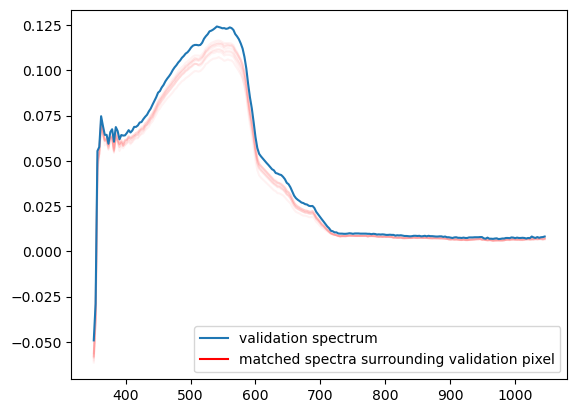

In [12]:
i = 300
matched_neighbours = pd.DataFrame(all_spectra[i], columns=wvs)
plt.plot(matched_neighbours.T, c="r", alpha=0.05);
plt.plot(kbay_validation_spectra.iloc[i], label="validation spectrum")
plt.plot([], c="r", label="matched spectra surrounding validation pixel")
plt.legend();

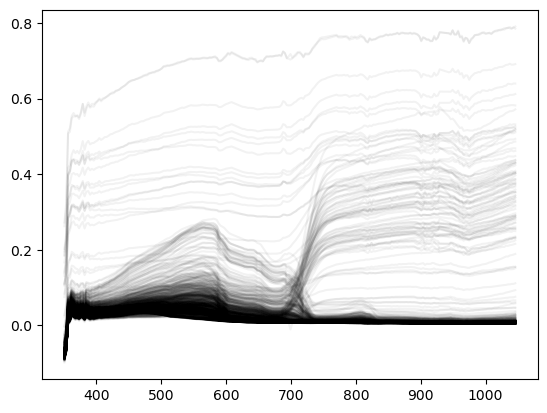

In [13]:
# quick comparison of unprojected vs projected data
unprojected_vals = spatial_xy_xa.values.reshape(kaneohe_ds.shape[0], -1).T
unprojected_df = pd.DataFrame(unprojected_vals, columns=hs_corrected_metadata.bands.centers)
# remove any rows containing -9999
unprojected_df = unprojected_df[~(unprojected_df == -9999).any(axis=1)]

plt.plot(unprojected_df[::1000].T, c="k", alpha=0.05);

In [14]:
spatial_xy_xa = envi_to_xarray_with_latlon(corr_fp)

mask_xa = envi_to_xarray_with_latlon(mask_fp)
# broadcast mask_xa to have same number of bands as scene_xa
mask_xa = mask_xa.broadcast_like(spatial_xy_xa)
mask_xa.values = np.broadcast_to(mask_xa.values[0], mask_xa.shape)
masked_scene_xa = spatial_xy_xa.where(mask_xa == 1, np.nan)
masked_scene_xa.name = "spectral_array"
spatial_xy_xa = masked_scene_xa
spatial_xy_xa.coords["band"] = hs_corrected_metadata.bands.centers

processed_xy_xa = ml_utils.spectral_xa_to_processed_spectral_df(spatial_xy_xa)

In [15]:
def envi_to_xarray(envi_fp, band_vals: list[float]=None):
    # Open the ENVI file using rasterio
    with rasterio.open(envi_fp) as src:
        data = src.read()
        transform = src.transform
        height, width = src.shape

        # generate coordinates from pixel indices using the affine transform
        x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
        x_coords, y_coords = rasterio.transform.xy(transform, y_coords, x_coords)

        # Convert the coordinates to numpy arrays
        x_coords = np.array(x_coords)
        y_coords = np.array(y_coords)

        # Reshape coordinates to match the image dimensions
        x_coords = np.reshape(x_coords, (height, width))
        y_coords = np.reshape(y_coords, (height, width))

        # Create the xarray Dataset with original coordinates
        dataset = xa.DataArray(
            data=data,  # The raster data
            dims=("band", "y", "x"),  # Dimensions of the data (e.g., bands, rows, cols)
            coords={
                "x": (["y", "x"], x_coords),  # Original x coordinates (reshaped)
                "y": (["y", "x"], y_coords),  # Original y coordinates (reshaped)
                "band": band_vals if band_vals else np.arange(1, data.shape[0] + 1),  # Band indices
            },
            attrs=src.meta  # Include the ENVI metadata
        )
        # convert nan values (-9999) to np.nan
        dataset = dataset.where(dataset != -9999, np.nan)
        dataset.rio.write_crs(src.crs, inplace=True)
        
    return dataset

corr_utm = envi_to_xarray(corr_fp)
mask_utm = envi_to_xarray(mask_fp)
mask_utm = mask_utm.broadcast_like(corr_utm)
mask_utm.values = np.broadcast_to(mask_utm.values[0], mask_utm.shape)
corr_utm = corr_utm.where(mask_utm == 1, np.nan)
corr_utm.coords["band"] = hs_corrected_metadata.bands.centers

In [16]:
import geopandas as gpd

points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(kbay_metadata.X, kbay_metadata.Y), crs="EPSG:4326")
points_utm = points.to_crs("EPSG:32604")
points_utm.head()

geometry
0  POINT (621677.698 2374791.683)
1  POINT (621677.698 2374791.683)
2  POINT (621677.698 2374791.683)
3  POINT (621677.698 2374791.683)
4  POINT (621312.049 2377085.684)

In [17]:
xy_matched_data = pd.DataFrame()
xy_matched_data["pixel_x"] = np.argmin(np.abs(corr_utm.x.values[0, :] - points_utm.geometry.x.values[:, np.newaxis]), axis=1)
xy_matched_data["pixel_y"] = np.argmin(np.abs(corr_utm.x.values[:, 0] - points_utm.geometry.x.values[:, np.newaxis]), axis=1)

# select kbay spectra
xy_matched_spectra = pd.DataFrame(spatial_xy_xa.values[:, xy_matched_data.pixel_y, xy_matched_data.pixel_x].T, columns=wvs)
xy_matched_spectra

350.718109   353.548370   356.378662   359.209045   362.039459   \
0      -0.071665    -0.046762     0.037529     0.043516     0.059201   
1      -0.071665    -0.046762     0.037529     0.043516     0.059201   
2      -0.071665    -0.046762     0.037529     0.043516     0.059201   
3      -0.071665    -0.046762     0.037529     0.043516     0.059201   
4      -0.059275    -0.041888     0.046145     0.050803     0.062679   
..           ...          ...          ...          ...          ...   
416    -0.069299    -0.051337     0.031579     0.033560     0.052030   
417    -0.074323    -0.049604     0.029695     0.035482     0.050644   
418    -0.074323    -0.049604     0.029695     0.035482     0.050644   
419    -0.074323    -0.049604     0.029695     0.035482     0.050644   
420    -0.074323    -0.049604     0.029695     0.035482     0.050644   

     364.869934   367.700500   370.531067   373.361725   376.192444   ...  \
0       0.055915     0.052294     0.052849     0.046282     0.052379  ...   
1       0.055915     0.052294     0.052849     0.046282     0.052379  ...   
2       0.055915     0.052294     0.052849     0.046282     0.052379  ...   
3       0.055915     0.052294     0.052849     0.046282     0.052379  ...   
4       0.059295     0.056563     0.055830     0.051854     0.056863  ...   
..           ...          ...          ...          ...          ...  ...   
416     0.049013     0.043109     0.043527     0.038827     0.043097  ...   
417     0.048752     0.043000     0.042289     0.040978     0.044435  ...   
418     0.048752     0.043000     0.042289     0.040978     0.044435  ...   
419     0.048752     0.043000     0.042289     0.040978     0.044435  ...   
420     0.048752     0.043000     0.042289     0.040978     0.044435  ...   

     1020.218201  1023.061768  1025.905273  1028.749023  1031.592651  \
0       0.007945     0.007283     0.007848     0.007280     0.007613   
1       0.007945     0.007283     0.007848     0.007280     0.007613   
2       0.007945     0.007283     0.007848     0.007280     0.007613   
3       0.007945     0.007283     0.007848     0.007280     0.007613   
4       0.008577     0.008896     0.008387     0.009256     0.008384   
..           ...          ...          ...          ...          ...   
416     0.006414     0.006648     0.006287     0.006338     0.006221   
417     0.006581     0.006388     0.006132     0.006483     0.006523   
418     0.006581     0.006388     0.006132     0.006483     0.006523   
419     0.006581     0.006388     0.006132     0.006483     0.006523   
420     0.006581     0.006388     0.006132     0.006483     0.006523   

     1034.436401  1037.280273  1040.124146  1042.968018  1045.812012  
0       0.006943     0.007621     0.008453     0.007771     0.007863  
1       0.006943     0.007621     0.008453     0.007771     0.007863  
2       0.006943     0.007621     0.008453     0.007771     0.007863  
3       0.006943     0.007621     0.008453     0.007771     0.007863  
4       0.008733     0.008781     0.008716     0.009414     0.011117  
..           ...          ...          ...          ...          ...  
416     0.006384     0.006621     0.007208     0.006925     0.006716  
417     0.006547     0.006792     0.005925     0.006598     0.006284  
418     0.006547     0.006792     0.005925     0.006598     0.006284  
419     0.006547     0.006792     0.005925     0.006598     0.006284  
420     0.006547     0.006792     0.005925     0.006598     0.006284  

[421 rows x 246 columns]

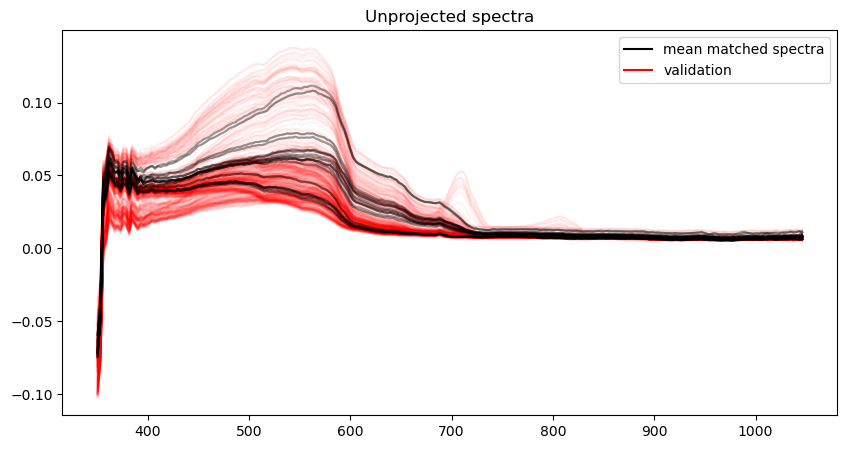

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
plt.plot(kbay_validation_spectra.T, c="r", alpha=0.05);
plt.plot(xy_matched_spectra.T, c="k", alpha=0.05);

plt.plot([], c="k", label="mean matched spectra")
plt.plot([], c="r", label="validation")
plt.title("Unprojected spectra")
plt.legend();

# Doing ML on reverse-matched spectra

In [35]:
np.random.seed(42)
new_labels = labels + np.random.normal(0, 0.1, size=labels.shape)
# normalise rows to sum to 1
# new_labels = new_labels / new_labels.sum(axis=1)[:, np.newaxis]
# new_labels

new_labels = new_labels.div(new_labels.sum(axis=1), axis=0)
new_labels*100

algae      coral       sand
198  97.951119   1.984177   0.064704
6    38.762975  51.048570  10.188455
305  80.007733  20.039127  -0.046859
291  33.067039  66.979552  -0.046591
158  34.140144  66.032935  -0.173080
..         ...        ...        ...
412  71.931420  26.065096   2.003485
413  72.861479  27.044837   0.093684
416  73.068638  27.008519  -0.077156
417  80.930633  19.088755  -0.019389
419  81.105991  18.830363   0.063646

[673 rows x 3 columns]

In [ ]:
N = 1000
noise_level = 1
np.random.normal(0, noise_level, size=N)

In [10]:
# find number of unique rows in df
y_train.drop_duplicates().shape[0]

44

N train samples: 504
N features: 84
N test samples: 169
Label dimensions: 3
Label shape: (673, 3)
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV took 104.30 seconds for 500 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.465 (std: 0.438)
Parameters: {'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Model with rank: 2
Mean validation score: 0.465 (std: 0.438)
Parameters: {'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
Model with rank: 3
Mean validation score: 0.465 (std: 0.438)
Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}


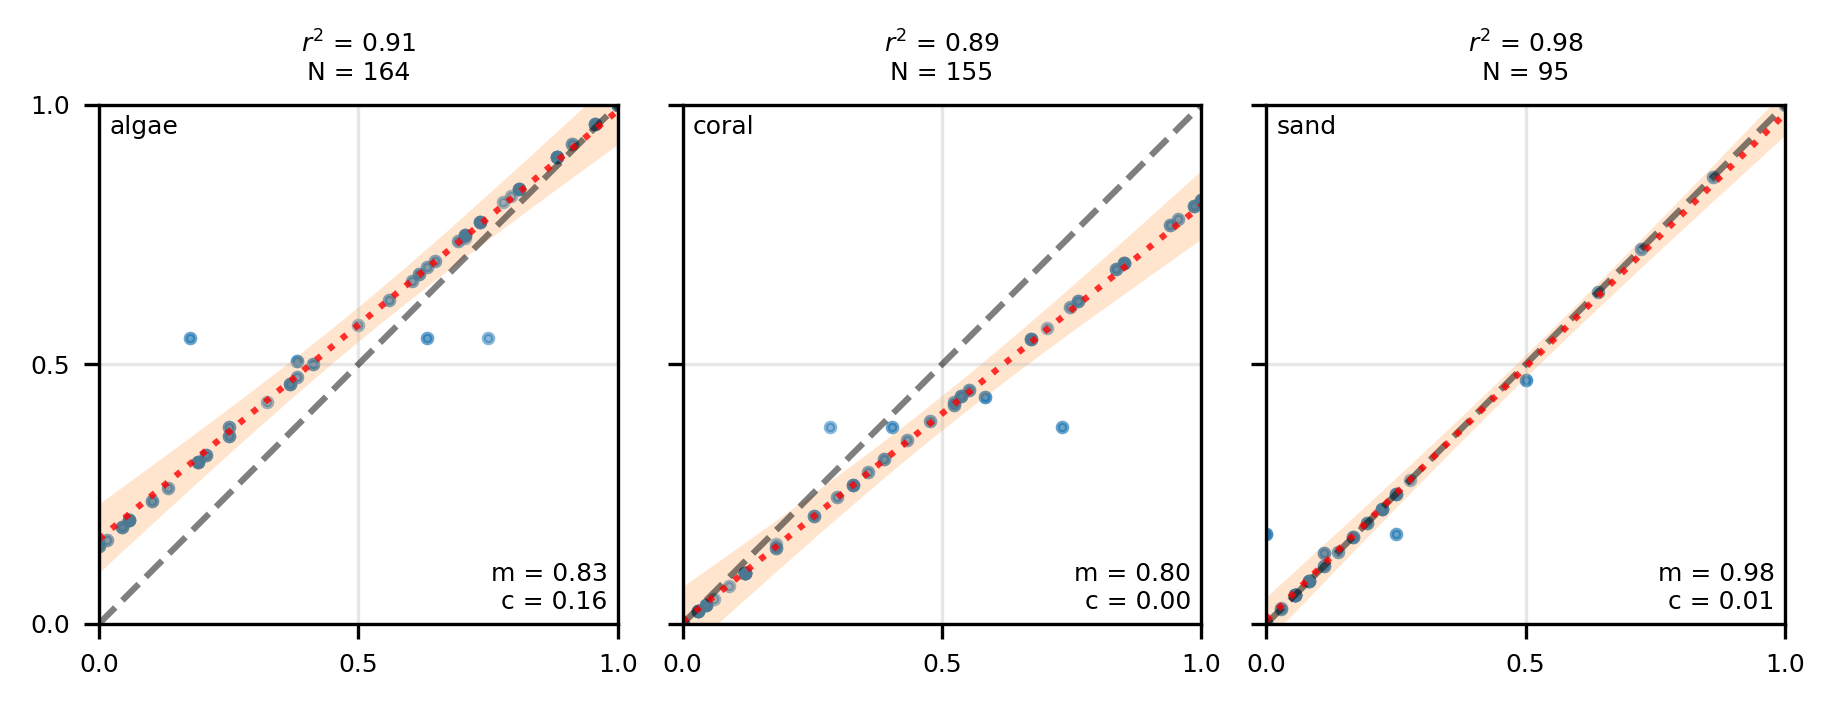

In [46]:
# scale depth data
(X_train, X_test), (y_train, y_test), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember", data_source="kaneohe_fits", train_ratio=0.6, noise_level=0).generate_data()

print("N train samples:", X_train.shape[0])
print("N features:", X_train.shape[1])
print("N test samples:", X_test.shape[0])
print("Label dimensions:", y_train.shape[1])
print("Label shape:", labels.shape)
kbay_rf = ml_utils.sklModels(model_type="random_forest", n_iter_search=500).return_fitted_model(X_train, y_train)

test_data = y_test
pred_data = kbay_rf.predict(X_test)

test_inds = X_test.index

plotting.plot_regression_results(test_data, pred_data, labels.iloc[test_inds], 
                            #   metadata=metadata,
                              color_by="Locale");

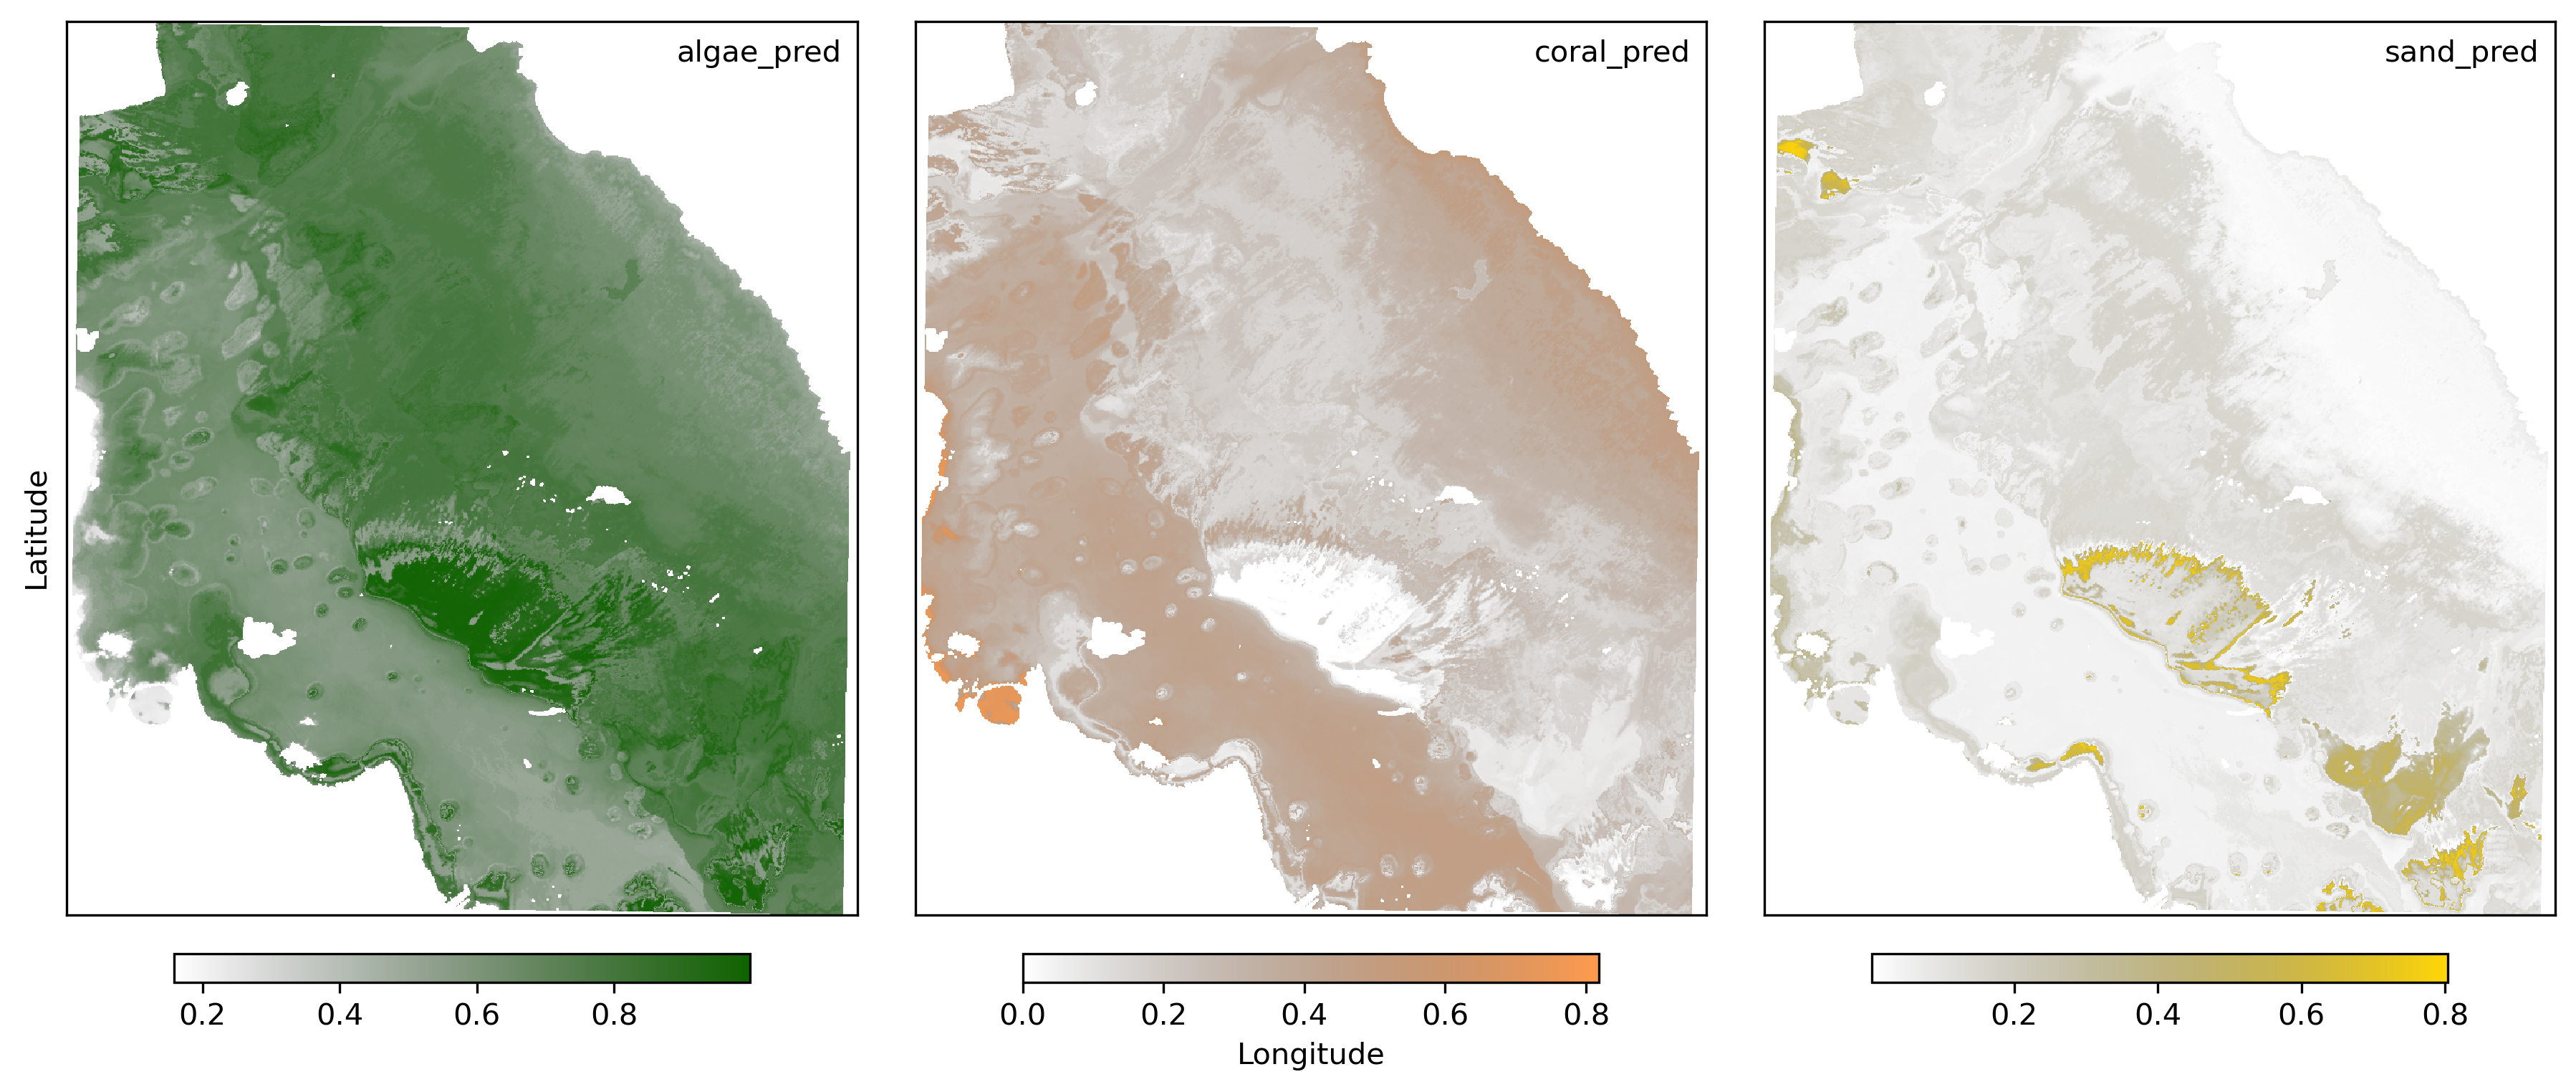

In [47]:
# apply to wider scene
scene_xa = xa.open_dataset(file_ops.KANEOHE_HS_FP).site
masked_scene_vals = scene_xa.values.reshape(scene_xa.sizes["band"], -1)

wvs = scene_xa.band.values
hs_vals = pd.DataFrame(masked_scene_vals.T, columns=wvs)
# process: deglint and crop to sensor range
hs_vals = spectrum_utils.deglint_spectra(hs_vals)
hs_vals = spectrum_utils.crop_spectra_to_range(hs_vals)
no_nan_hs_vals = hs_vals.dropna()

endmember_inferred = ml_utils.infer_on_spatial(kbay_rf, scene_xa, ["algae", "coral", "sand"])

# cmap = sns.color_palette("rocket", as_cmap=True)
# create cmap for coral: from transparent to coral colour
from matplotlib.colors import LinearSegmentedColormap
coral_hex = "#ff9b4f"
algae_hex = "#0f6300"
sand_hex = "#ffd608"

coral_cmap = LinearSegmentedColormap.from_list("coral", ["#00000000", coral_hex])
algae_cmap = LinearSegmentedColormap.from_list("algae", ["#00000000", algae_hex])
sand_cmap = LinearSegmentedColormap.from_list("sand", ["#00000000", sand_hex])

fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True, dpi=300)

pred_vars = [var for var in endmember_inferred.data_vars if re.search(r'_pred$', var)]
min_values = [np.nanmin(endmember_inferred[var].values) for var in pred_vars]
max_values = [np.nanmax(endmember_inferred[var].values) for var in pred_vars]

for i, (var_cmap, var) in enumerate(zip([algae_cmap, coral_cmap, sand_cmap], ["algae_pred", "coral_pred", "sand_pred"])):
    im = endmember_inferred[var].plot.imshow(ax=ax[i], cmap=var_cmap, add_colorbar=False, 
                                                # vmin=min(min_values), vmax=max(max_values)
                                                )
    ax[i].text(
        0.98, 0.98, var, transform=ax[i].transAxes, ha='right', va='top',
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_yticklabels([])
    ax[i].set_aspect('equal')
    fig.colorbar(im, ax=ax[i], orientation='horizontal', fraction=0.03, pad=0.04)

fig.text(0.5, 0.0, 'Longitude', ha='center')
fig.text(0, 0.5, 'Latitude', va='center', rotation='vertical')

fig.tight_layout()